In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression

sns.set()  # set the style

In [2]:
#get dataset
df = pd.read_csv('./diagnosis_migraine_pc.csv')

#rename gender to sex
df.rename(columns={'Gender': 'Sex'}, inplace=True)

#rename diagnosis migraine pc to treatment
df.rename(columns={'Diagnosis migraine PC': 'Treatment'}, inplace=True)

print(df.head)

<bound method NDFrame.head of     Sample name derivation cohort acute_blood_thinner afib_all Afib_electro  \
0     FSTIA0549                No                 NaN       No          NaN   
1     FSTIA0509               Yes                 NaN       No          NaN   
2     FSTIA0026                No                 NaN       No          NaN   
3     FSTIA0036                No                 NaN       No          NaN   
4     FSTIA0038                No                 NaN       No          NaN   
..          ...               ...                 ...      ...          ...   
394   FSTIA0690               Yes                 NaN       No          NaN   
395   FSTIA0691               Yes                 NaN       No          NaN   
396   FSTIA0698               Yes                 NaN       No          NaN   
397   FSTIA0710               Yes                 NaN       No           No   
398   FSTIA0716               Yes         Rivaroxaban       No          NaN   

      Age Aggrenox_ac

/var/folders/g1/j563bz656cl84jb7pbtnznt00000gn/T/ipykernel_92377/198669315.py:2: DtypeWarning: Columns (15,16,18,19,26,27,31,53,62,63,64,65,77,78,79,80,82) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./diagnosis_migraine_pc.csv')


In [3]:
#transform categorical variables into 0's and 1's

#for variable gender  "female" = 1, "male" = 0
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == "Female" else 0)

#for variable hypercholesterolemia, "no" = 1, "yes" = 0
df['Hypercholesterolemia'] = df['Hypercholesterolemia'].apply(lambda x: 1 if x == "No" else 0)

#for variable diabetes, "no" = 1, "yes" = 0
df['Diabetes'] = df['Diabetes'].apply(lambda x: 1 if x == "No" else 0)

#for variable hypertension_history, "no" = 1, "yes" = 0
df['Hypertension_history'] = df['Hypertension_history'].apply(lambda x: 1 if x == "No" else 0)

# print(df['Sex'], df['Hypercholesterolemia'], df['Diabetes'], df['Hypertension_history'])

In [4]:
#create dataframe based on select columns only

df2 = df[['Sample name', 'Treatment', 'Age', 'Sex', 'Hypercholesterolemia', 'Diabetes', 'Hypertension_history']]


df2

,Sample name,Treatment,Age,Sex,Hypercholesterolemia,Diabetes,Hypertension_history
0,FSTIA0549,Mimic_migraine,48.0,0,0,1,0
1,FSTIA0509,Mimic_migraine,55.0,1,1,1,1
2,FSTIA0026,Mimic_migraine,47.0,0,1,1,1
3,FSTIA0036,Mimic_migraine,72.0,1,1,0,1
4,FSTIA0038,Mimic_migraine,65.0,1,1,1,1
...,...,...,...,...,...,...,...
394,FSTIA0690,VRFC,58.3,1,1,1,0
395,FSTIA0691,VRFC,67.0,0,0,0,0
396,FSTIA0698,VRFC,67.0,1,0,1,1
397,FSTIA0710,VRFC,81.7,1,1,1,1


In [5]:

#VRFC is 0 and treatments are 1

def make_binary(temp_df, column_name, value_name, is_flipped):
    if is_flipped:
        return temp_df[column_name].apply(lambda x: 0 if x == value_name else 1)
    return temp_df[column_name].apply(lambda x: 1 if x == value_name else 0)
#separate control and treatment for t-test
df2_control = df2[df2.Treatment == 'VRFC']
print(df2_control.shape)
df2_control.loc[:, 'Treatment'] = make_binary(df2_control, 'Treatment', 'VRFC', False)
#VRFC = 1, everything else is 0

df2_treatment_1 = df2[df2.Treatment == 'Mimic_no-migraine']
print(df2_treatment_1.shape)
df2_treatment_1 = pd.concat([df2_control, df2_treatment_1], ignore_index=True)
df2_treatment_1.loc[:, 'Treatment'] = make_binary(df2_treatment_1, 'Treatment', 'Mimic_no-migraine', True)
print(df2_treatment_1.shape, 'treatment 1')
#Treatment 1 = 0, VRFC = 1

df2_treatment_2 = df2[df2.Treatment == 'Mimic_migraine']
print(df2_treatment_2.shape)
df2_treatment_2 = pd.concat([df2_control, df2_treatment_2], ignore_index=True)
df2_treatment_2.loc[:, 'Treatment'] = make_binary(df2_treatment_2, 'Treatment', 'Mimic_migraine', True)
print(df2_treatment_2.shape, 'treatment 2')

df2_treatment_3 = df2[df2.Treatment == 'True TIA']
print(df2_treatment_3.shape)
df2_treatment_3 = pd.concat([df2_control, df2_treatment_3], ignore_index=True)
df2_treatment_3.loc[:, 'Treatment'] = make_binary(df2_treatment_3, 'Treatment', 'True TIA', True)
print(df2_treatment_3.shape, 'treatment 3')

(133, 7)
(76, 7)
(209, 7) treatment 1
(45, 7)
(178, 7) treatment 2
(145, 7)
(278, 7) treatment 3


In [6]:
# make X a df of categorical variables
def conduct_lr(temp_df):

    X = temp_df[['Age', 'Sex', 'Hypercholesterolemia', 'Diabetes', 'Hypertension_history']]
    y = temp_df['Treatment']
    y = y.astype('int')

    # print(X.head())
    # print()
    # print(y.head())
    # print('don')
    # propensity score matching using logistic regression
    lr = LogisticRegression()
    lr.fit(X,y)
    # print(lr.coef_.ravel())
    # print(X.columns.to_numpy())
    coeffs = pd.DataFrame({
        'column':X.columns.to_numpy(),
        'coeff':lr.coef_.ravel(),
    })
    # print(coeffs)
    # prediction
    pred_binary = lr.predict(X)  # binary 0 control, 1, treatment
    pred_prob = lr.predict_proba(X)  # probabilities for classes

    print('the binary prediction is:', pred_binary[0])
    print('the corresponding probabilities are:', pred_prob[0])
    return pred_prob[:, 1]

# make y a df of control and treatment groups

In [7]:
df2_treatment_1['ps'] = conduct_lr(df2_treatment_1)
df2_treatment_2['ps'] = conduct_lr(df2_treatment_2)
df2_treatment_3['ps'] = conduct_lr(df2_treatment_3)

the binary prediction is: 1
the corresponding probabilities are: [0.43288586 0.56711414]
the binary prediction is: 1
the corresponding probabilities are: [0.232729 0.767271]
the binary prediction is: 0
the corresponding probabilities are: [0.50735192 0.49264808]


In [8]:
# calculate the logit of the propensity score for matching if needed
# I just use the propensity score to match in this tutorial
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

df2_treatment_1['ps_logit'] = df2_treatment_1.ps.apply(lambda x: logit(x))
df2_treatment_2['ps_logit'] = df2_treatment_2.ps.apply(lambda x: logit(x))
df2_treatment_3['ps_logit'] = df2_treatment_3.ps.apply(lambda x: logit(x))


df2_treatment_1.head()

,Sample name,Treatment,Age,Sex,Hypercholesterolemia,Diabetes,Hypertension_history,ps,ps_logit
0,FSTIA0198,1,67.8,1,0,1,1,0.567114,0.270086
1,FSTIA0227,1,58.2,0,1,1,1,0.691557,0.807410
2,FSTIA0451,1,47.0,0,0,0,0,0.756078,1.131298
3,FSTIA0502,1,34.0,0,1,1,1,0.821295,1.525144
4,FSTIA0605,1,64.0,0,0,1,1,0.643096,0.588827


<Axes: xlabel='ps', ylabel='Count'>

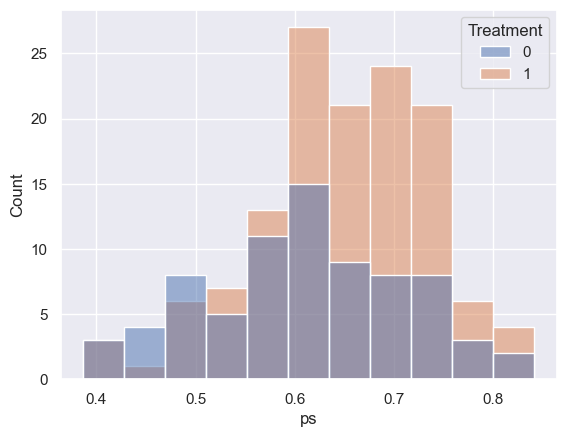

In [9]:
# lr1 = LogisticRegression(max_iter=1000)
# lr1.fit(X, y)

# pred_prob1 = lr1.predict_proba(X)  # probabilities for classes
# df2_treatment_1['ps1'] = pred_prob1[:, 1]

sns.histplot(data=df2_treatment_1, x='ps', hue='Treatment')


<Axes: xlabel='ps', ylabel='Count'>

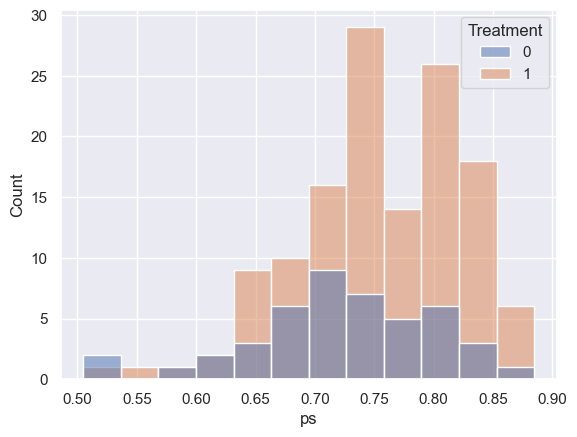

In [10]:
sns.histplot(data=df2_treatment_2, x='ps', hue='Treatment')


<Axes: xlabel='ps', ylabel='Count'>

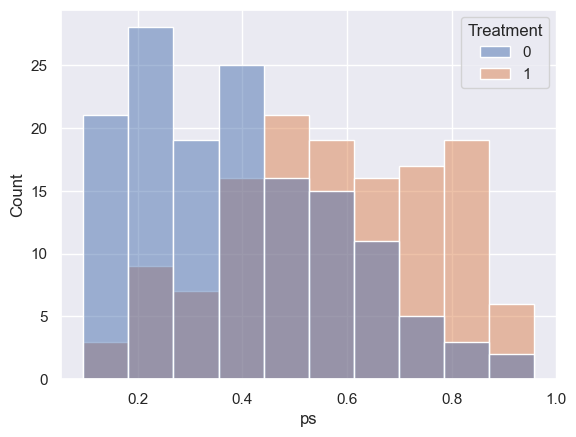

In [11]:
sns.histplot(data=df2_treatment_3, x='ps', hue='Treatment')

In [12]:
### TREATMENT 1

# user 25% of std dev of propensity core as the radius

#get the k closest neighbors for each observations

#relax caliper and increase k can provide more matches

from sklearn.neighbors import NearestNeighbors

caliper = np.std(df2_treatment_1.ps) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

ps = df2_treatment_1[['ps']]  # double brackets as a dataframe
knn.fit(ps)

caliper (radius) is: 0.0236


NearestNeighbors(n_neighbors=10, radius=0.023570477982219326)

In [13]:
distances, neighbor_indexes = knn.kneighbors(ps)

print(neighbor_indexes.shape)

# the 10 closest points to the first point
print(distances[0])
print(neighbor_indexes[0])

print(df2.shape)
print(neighbor_indexes.shape)

(209, 10)
[0.         0.00012444 0.00049582 0.00065987 0.0026923  0.0026923
 0.00327194 0.00362273 0.00581527 0.00701955]
[  0  82 159 190  90 185 166 192 130 202]
(399, 7)
(209, 10)


In [14]:
matched_control = []  # keep track of the matched observations in control

for current_index, row in df2_treatment_1.iterrows():  # iterate over the dataframe
    if row.Treatment == 1:  # the current row is in the control group
        df2_treatment_1.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            if (current_index != idx) and (df2_treatment_1.loc[idx].Treatment == 1):
                if idx not in matched_control:  # this control has not been matched yet
                    df2_treatment_1.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

print('total mimic_no_migraine observations in treatment:', len(df2_treatment_1[df2_treatment_1.Treatment==0]))
print('total matched observations in control:', len(matched_control))

total mimic_no_migraine observations in treatment: 76
total matched observations in control: 71


In [15]:
# control have no match
treatment_matched = df2_treatment_1.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = df2_treatment_1.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df2_treatment_1_matched = pd.concat([treatment_matched, control_matched])

df2_treatment_1_matched.Treatment.value_counts()

Treatment
0    71
1    71
Name: count, dtype: int64

In [16]:
df2_treatment_1_matched_control = df2_treatment_1_matched[df2_treatment_1_matched.Treatment==1]
df2_treatment_1_matched_treatment = df2_treatment_1_matched[df2_treatment_1_matched.Treatment==0]

In [17]:
from scipy.stats import ttest_ind
print(df2_treatment_1_matched_control.Age.mean(), df2_treatment_1_matched_treatment.Age.mean())

# compare samples
_, p = ttest_ind(df2_treatment_1_matched_control.Age, df2_treatment_1_matched_treatment.Age)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

63.118309859154934 63.05070422535212
p=0.976
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


In [18]:
from scipy.stats import ttest_ind

print(df2_control.Age.mean(), df2_treatment_1.Age.mean())

# compare samples
_, p = ttest_ind(df2_control.Age, df2_treatment_1.Age)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

59.22706766917293 61.1421052631579
p=0.192
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


In [19]:
""" from numpy import mean
from numpy import var
from math import sqrt
 
# function to calculate Cohen's d for independent samples
def cohen_d(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = mean(d1), mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

effect_sizes = []
cols = ['Age', 'Hypercholesterolemia', 'Diabetes', 'Hypertension_history', 'Sex']

for cl in cols:
    _, p_before = ttest_ind(df2_control[cl], df2_treatment_1[cl])
    _, p_after = ttest_ind(df2_treatment_1_matched_control[cl], df2_treatment_1_matched_treatment[cl])
    cohen_d_before = cohen_d(df2_treatment_1[cl], df2_control[cl])
    cohen_d_after = cohen_d(df2_treatment_1_matched_treatment[cl], df2_treatment_1_matched_control[cl])
    effect_sizes.append([cl,'before', cohen_d_before, p_before])
    effect_sizes.append([cl,'after', cohen_d_after, p_after])
    

df_effect_sizes_treatment_1 = pd.DataFrame(effect_sizes, columns=['feature', 'matching', 'effect_size', 'p-value'])
df_effect_sizes_treatment_1
 fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_effect_sizes_treatment_1, x='effect_size', y='feature', hue='matching', orient='h')
""" 

" from numpy import mean\nfrom numpy import var\nfrom math import sqrt\n \n# function to calculate Cohen's d for independent samples\ndef cohen_d(d1, d2):\n\t# calculate the size of samples\n\tn1, n2 = len(d1), len(d2)\n\t# calculate the variance of the samples\n\ts1, s2 = var(d1, ddof=1), var(d2, ddof=1)\n\t# calculate the pooled standard deviation\n\ts = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))\n\t# calculate the means of the samples\n\tu1, u2 = mean(d1), mean(d2)\n\t# calculate the effect size\n\treturn (u1 - u2) / s\n\neffect_sizes = []\ncols = ['Age', 'Hypercholesterolemia', 'Diabetes', 'Hypertension_history', 'Sex']\n\nfor cl in cols:\n    _, p_before = ttest_ind(df2_control[cl], df2_treatment_1[cl])\n    _, p_after = ttest_ind(df2_treatment_1_matched_control[cl], df2_treatment_1_matched_treatment[cl])\n    cohen_d_before = cohen_d(df2_treatment_1[cl], df2_control[cl])\n    cohen_d_after = cohen_d(df2_treatment_1_matched_treatment[cl], df2_treatment_1_matched_control

In [20]:
from psmpy import PsmPy
from psmpy.plotting import *

In [21]:
df_psmpy_treatment_1 = df2_treatment_1_matched

print(df_psmpy_treatment_1)

    Sample name Treatment   Age  Sex  Hypercholesterolemia  Diabetes  \
133   FSTIA0172         0  52.0    0                     1         1   
134   FSTIA0373         0  80.0    1                     1         0   
135   FSTIA0480         0  58.0    1                     1         1   
136   FSTIA0600         0  51.0    1                     1         1   
137   FSTIA0335         0  88.0    1                     1         1   
..          ...       ...   ...  ...                   ...       ...   
30    FSTIA0522         1  67.1    1                     0         0   
47    FSTIA0739         1  51.0    0                     1         0   
54    FSTIA0072         1  70.0    1                     0         1   
106   FSTIA0619         1  43.2    0                     1         1   
125   FSTIA0515         1  47.0    0                     1         1   

     Hypertension_history        ps  ps_logit  matched  
133                     1  0.729343  0.991292     17.0  
134                  

In [22]:

psm = PsmPy(df_psmpy_treatment_1, treatment='Treatment', indx='Sample name', exclude = ['Age', 'Hypercholesterolemia', 'Diabetes', 'matched', 'Hypertension_history', 'Sex'])


In [23]:
psm.logistic_ps(balance=False)
psm.predicted_data

,Sample name,ps,ps_logit,propensity_score,propensity_logit,Treatment
0,FSTIA0180,0.729928,0.994258,0.499540,-0.001841,1
1,FSTIA0578,0.493881,-0.024478,0.500506,0.002023,1
2,FSTIA0691,0.631377,0.538130,0.499972,-0.000111,1
3,FSTIA0511,0.692821,0.813342,0.499711,-0.001155,1
4,FSTIA0594,0.423911,-0.306739,0.500773,0.003093,1
...,...,...,...,...,...,...
137,FSTIA0638,0.585204,0.344175,0.500156,0.000625,0
138,FSTIA0663,0.740892,1.050609,0.499486,-0.002054,0
139,FSTIA0031,0.527093,0.108478,0.500380,0.001519,0
140,FSTIA0609,0.773841,1.230130,0.499316,-0.002735,0


In [24]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

/Users/amalsorathia/anaconda3/lib/python3.11/site-packages/psmpy/psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


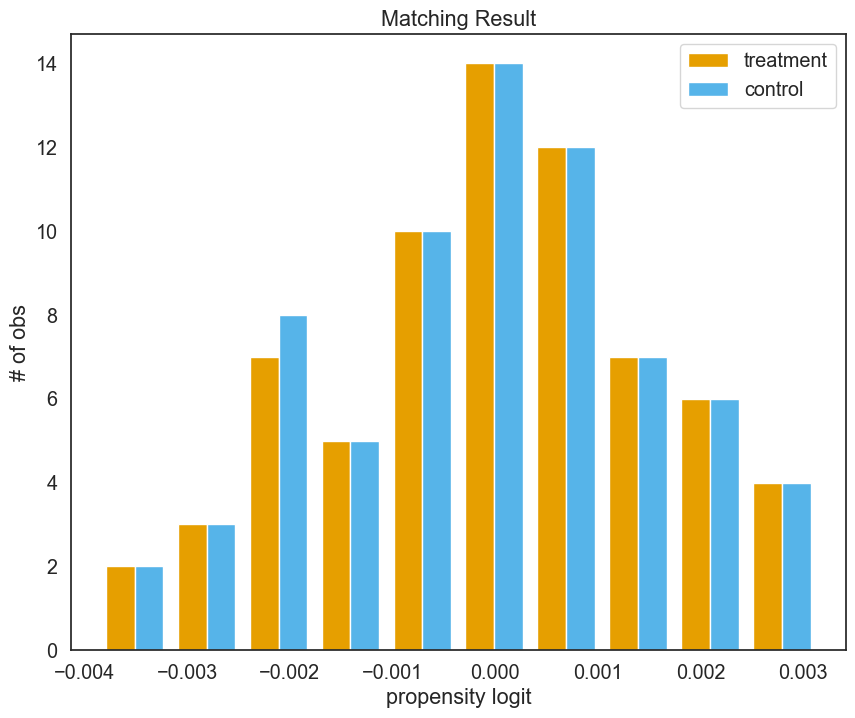

In [25]:
psm.plot_match(Title='Matching Result', Ylabel='# of obs', Xlabel= 'propensity logit', names = ['treatment', 'control'])

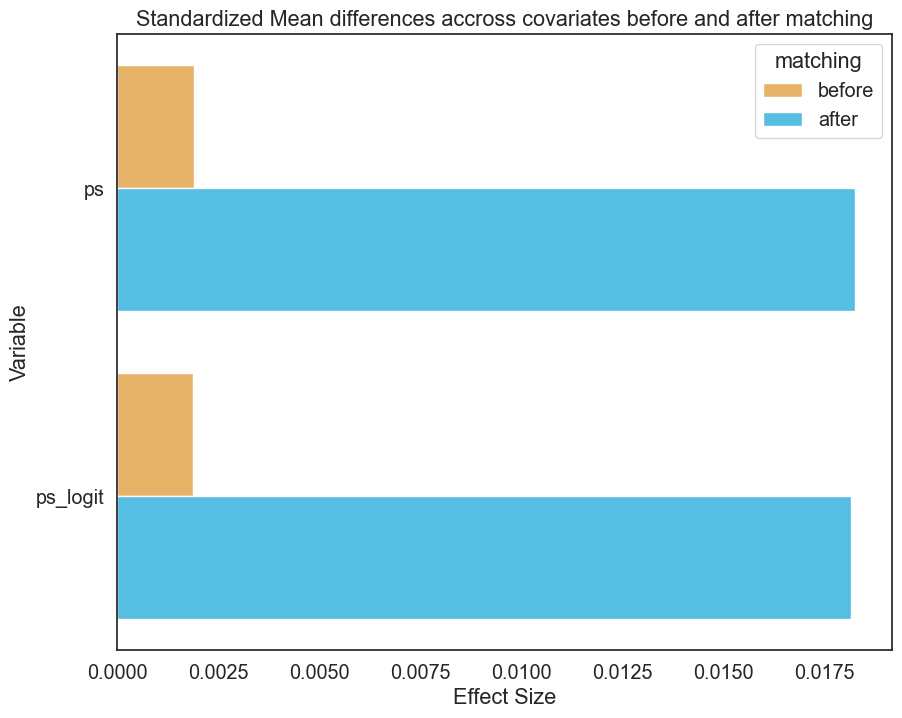

In [26]:
psm.effect_size_plot()

In [27]:
### TREATMENT 2

# user 25% of std dev of propensity core as the radius

#get the k closest neighbors for each observations

#relax caliper and increase k can provide more matches

from sklearn.neighbors import NearestNeighbors

caliper = np.std(df2_treatment_2.ps) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

ps = df2_treatment_2[['ps']]  # double brackets as a dataframe
knn.fit(ps)

distances, neighbor_indexes = knn.kneighbors(ps)

print(neighbor_indexes.shape)

# the 10 closest points to the first point
print(distances[0])
print(neighbor_indexes[0])

print(df2.shape)
print(neighbor_indexes.shape)

matched_control = []  # keep track of the matched observations in control

for current_index, row in df2_treatment_2.iterrows():  # iterate over the dataframe
    if row.Treatment == 1:  # the current row is in the control group
        df2_treatment_2.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            if (current_index != idx) and (df2_treatment_2.loc[idx].Treatment == 1):
                if idx not in matched_control:  # this control has not been matched yet
                    df2_treatment_2.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

print('total observations in treatment:', len(df2_treatment_2[df2_treatment_2.Treatment==0]))
print('total matched observations in control:', len(matched_control))


# control have no match
treatment_matched = df2_treatment_2.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = df2_treatment_2.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df2_treatment_2_matched = pd.concat([treatment_matched, control_matched])

df2_treatment_2_matched.Treatment.value_counts()


df2_treatment_2_matched_control = df2_treatment_2_matched[df2_treatment_2_matched.Treatment==1]
df2_treatment_2_matched_treatment = df2_treatment_2_matched[df2_treatment_2_matched.Treatment==0]

from scipy.stats import ttest_ind
print(df2_treatment_2_matched_control.Age.mean(), df2_treatment_2_matched_treatment.Age.mean())

# compare samples
_, p = ttest_ind(df2_treatment_2_matched_control.Age, df2_treatment_2_matched_treatment.Age)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

from scipy.stats import ttest_ind

print(df2_control.Age.mean(), df2_treatment_2.Age.mean())

# compare samples
_, p = ttest_ind(df2_control.Age, df2_treatment_2.Age)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

from psmpy import PsmPy
from psmpy.plotting import *

df_psmpy_treatment_2 = df2_treatment_2_matched
print(df_psmpy_treatment_2)


psm = PsmPy(df_psmpy_treatment_2, treatment='Treatment', indx='Sample name', exclude = ['Age', 'Hypercholesterolemia', 'Diabetes', 'matched', 'Hypertension_history', 'Sex'])
psm.logistic_ps(balance=False)
psm.predicted_data


caliper (radius) is: 0.0181
(178, 10)
[0.         0.00074813 0.00330148 0.00365938 0.00375159 0.00392578
 0.00541469 0.0054197  0.00560301 0.00643921]
[  0 168  18 130  17   5 116  46  78  91]
(399, 7)
(178, 10)
total observations in treatment: 45
total matched observations in control: 44
54.35681818181819 55.34318181818182
p=0.748
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)
59.22706766917293 58.19831460674157
p=0.494
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)
    Sample name Treatment   Age  Sex  Hypercholesterolemia  Diabetes  \
133   FSTIA0549         0  48.0    0                     0         1   
134   FSTIA0509         0  55.0    1                     1         1   
135   FSTIA0026         0  47.0    0                     1         1   
136   FSTIA0036         0  72.0    1                     1         0   
137   FSTIA0038         0  65.0    1                     1  

,Sample name,ps,ps_logit,propensity_score,propensity_logit,Treatment
0,FSTIA0429,0.654982,0.641009,0.498781,-0.004877,1
1,FSTIA0040,0.736372,1.027196,0.500220,0.000880,1
2,FSTIA0130,0.748241,1.089253,0.500452,0.001810,1
3,FSTIA0421,0.881251,2.004333,0.503915,0.015660,1
4,FSTIA0684,0.787266,1.308526,0.501276,0.005104,1
...,...,...,...,...,...,...
83,FSTIA0803,0.832818,1.605733,0.502399,0.009594,0
84,FSTIA0814,0.755872,1.130182,0.500606,0.002423,0
85,FSTIA0835,0.658428,0.656296,0.498838,-0.004650,0
86,FSTIA0836,0.726607,0.977477,0.500034,0.000137,0


In [28]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)


/Users/amalsorathia/anaconda3/lib/python3.11/site-packages/psmpy/psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


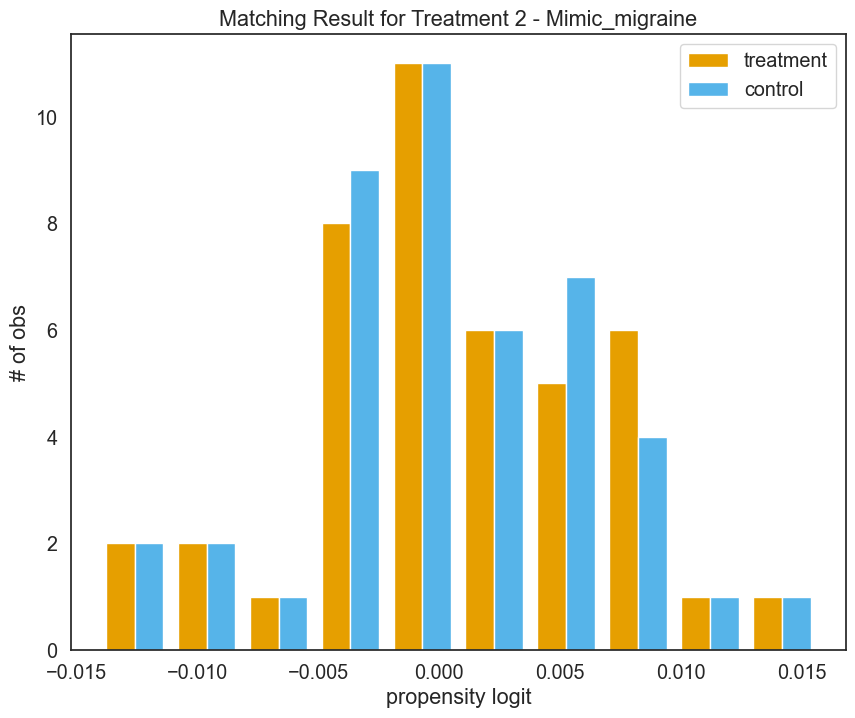

In [29]:
psm.plot_match(Title='Matching Result for Treatment 2 - Mimic_migraine', Ylabel='# of obs', Xlabel= 'propensity logit', names = ['treatment', 'control'])


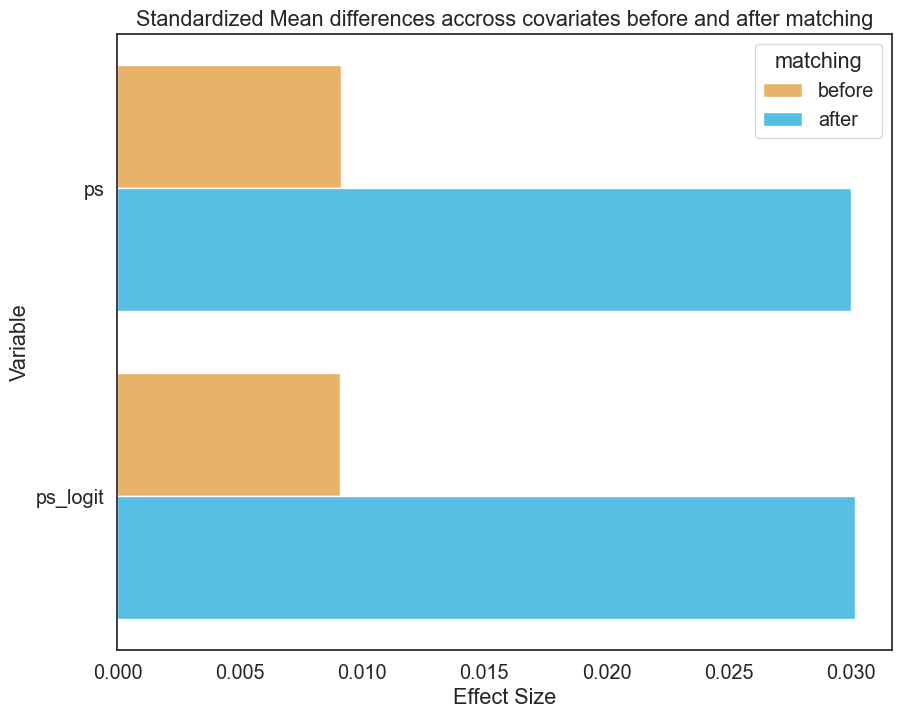

In [30]:
psm.effect_size_plot()

In [31]:
#Treatment 3

# user 25% of std dev of propensity core as the radius

#get the k closest neighbors for each observations

#relax caliper and increase k can provide more matches

from sklearn.neighbors import NearestNeighbors

caliper = np.std(df2_treatment_3.ps) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

ps = df2_treatment_3[['ps']]  # double brackets as a dataframe
knn.fit(ps)

distances, neighbor_indexes = knn.kneighbors(ps)

print(neighbor_indexes.shape)

# the 10 closest points to the first point
print(distances[0])
print(neighbor_indexes[0])

print(df2.shape)
print(neighbor_indexes.shape)

matched_control = []  # keep track of the matched observations in control

for current_index, row in df2_treatment_3.iterrows():  # iterate over the dataframe
    if row.Treatment == 1:  # the current row is in the control group
        df2_treatment_3.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            if (current_index != idx) and (df2_treatment_3.loc[idx].Treatment == 1):
                if idx not in matched_control:  # this control has not been matched yet
                    df2_treatment_3.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

print('total true TIA observations in treatment:', len(df2_treatment_3[df2_treatment_3.Treatment==0]))
print('total matched observations with True TIA in control:', len(matched_control))


# control have no match
treatment_matched = df2_treatment_3.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = df2_treatment_3.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df2_treatment_3_matched = pd.concat([treatment_matched, control_matched])

df2_treatment_3_matched.Treatment.value_counts()


df2_treatment_3_matched_control = df2_treatment_3_matched[df2_treatment_3_matched.Treatment==1]
df2_treatment_3_matched_treatment = df2_treatment_3_matched[df2_treatment_3_matched.Treatment==0]

from scipy.stats import ttest_ind
print(df2_treatment_3_matched_control.Age.mean(), df2_treatment_3_matched_treatment.Age.mean())

# compare samples
_, p = ttest_ind(df2_treatment_3_matched_control.Age, df2_treatment_3_matched_treatment.Age)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

from scipy.stats import ttest_ind

print(df2_control.Age.mean(), df2_treatment_3.Age.mean())

# compare samples
_, p = ttest_ind(df2_control.Age, df2_treatment_3.Age)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

from psmpy import PsmPy
from psmpy.plotting import *

df_psmpy_treatment_3 = df2_treatment_3_matched
print(df_psmpy_treatment_2)


psm = PsmPy(df_psmpy_treatment_3, treatment='Treatment', indx='Sample name', exclude = ['matched'])
psm.logistic_ps(balance=False)
psm.predicted_data


caliper (radius) is: 0.0538
(278, 10)
[0.         0.00097109 0.00097109 0.00339996 0.0034707  0.0048543
 0.00492504 0.00770559 0.01207781 0.01260095]
[  0 145 105 134 257  90   7 207 213 274]
(399, 7)
(278, 10)
total true TIA observations in treatment: 145
total matched observations with True TIA in control: 83
64.67831325301205 65.00963855421686
p=0.851
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)
59.22706766917293 65.35071942446044
p=0.000
different distributions/different group mean (reject H0)
    Sample name Treatment   Age  Sex  Hypercholesterolemia  Diabetes  \
133   FSTIA0549         0  48.0    0                     0         1   
134   FSTIA0509         0  55.0    1                     1         1   
135   FSTIA0026         0  47.0    0                     1         1   
136   FSTIA0036         0  72.0    1                     1         0   
137   FSTIA0038         0  65.0    1                     1         1   
..       

,Sample name,Age,Sex,Hypercholesterolemia,Diabetes,Hypertension_history,ps,ps_logit,propensity_score,propensity_logit,Treatment
0,FSTIA0402,69.0,1,1,1,1,0.487794,-0.048835,0.455210,-0.179643,1
1,FSTIA0144,72.0,0,1,1,1,0.409596,-0.365634,0.433375,-0.268095,1
2,FSTIA0246,70.9,0,0,1,0,0.339653,-0.664842,0.539011,0.156361,1
3,FSTIA0309,72.0,1,1,0,0,0.350555,-0.616602,0.477070,-0.091784,1
4,FSTIA0132,58.8,0,0,1,0,0.539473,0.158223,0.553096,0.213186,1
...,...,...,...,...,...,...,...,...,...,...,...
161,FSTIA0417,72.0,1,0,1,1,0.421870,-0.315102,0.493554,-0.025784,0
162,FSTIA0513,50.3,0,0,1,0,0.676210,0.736408,0.562908,0.252972,0
163,FSTIA0525,55.0,1,1,1,1,0.711662,0.903471,0.471490,-0.114163,0
164,FSTIA0612,62.3,0,0,1,0,0.480047,-0.079854,0.549015,0.196690,0


In [32]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)


/Users/amalsorathia/anaconda3/lib/python3.11/site-packages/psmpy/psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


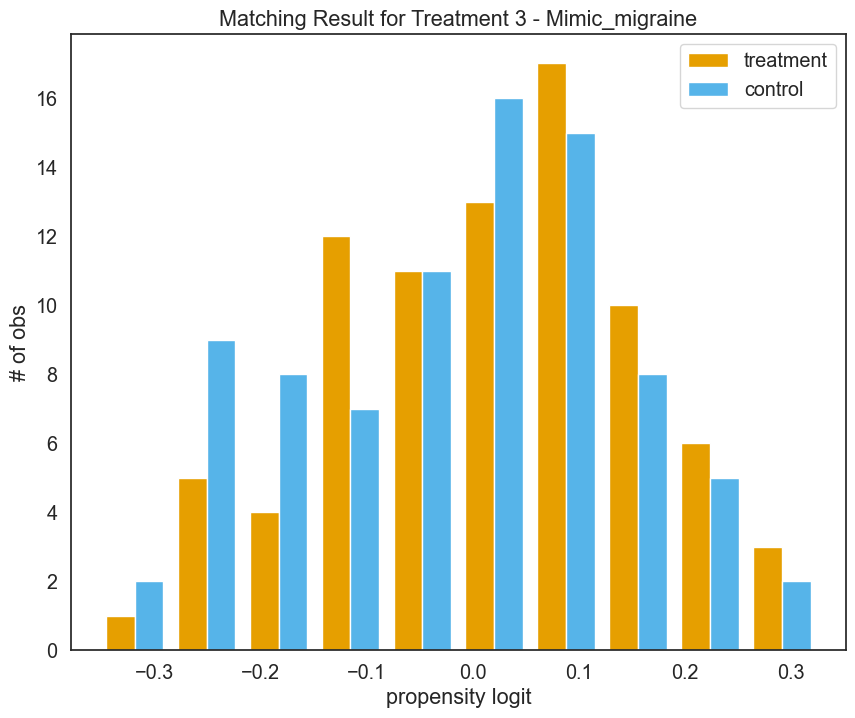

In [33]:
psm.plot_match(Title='Matching Result for Treatment 3 - Mimic_migraine', Ylabel='# of obs', Xlabel= 'propensity logit', names = ['treatment', 'control'])


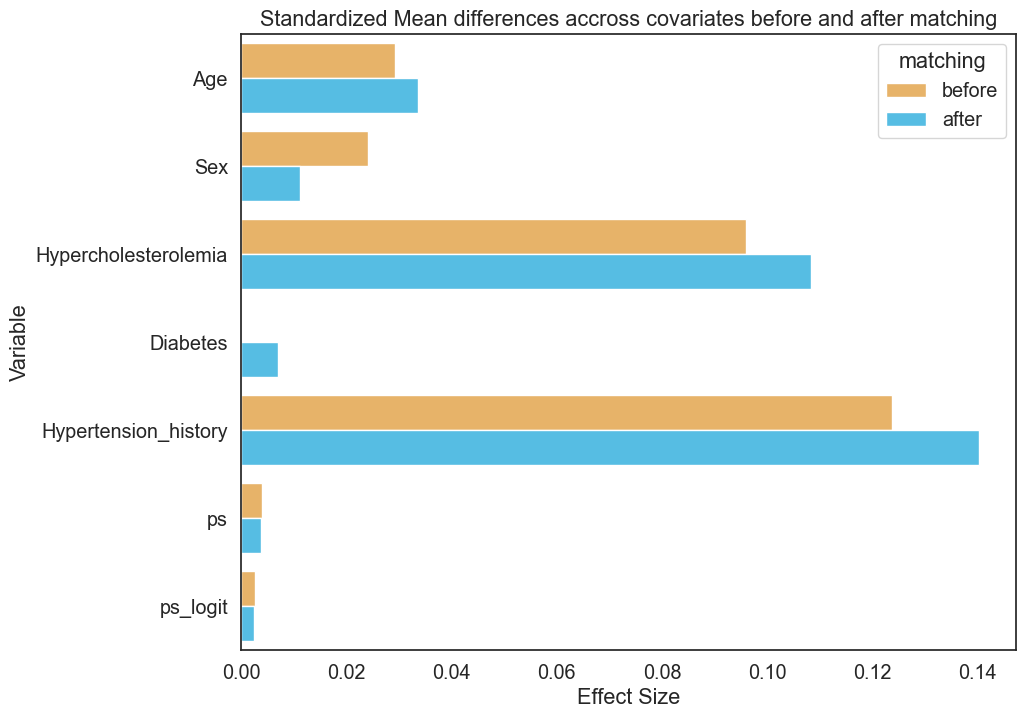

In [34]:
psm.effect_size_plot()

In [35]:
#FISHERS TEST ATTEMPT - TREATMENT 1 DIABETES

from scipy.stats import fisher_exact

print("TREATMENT 1 - MIMIC_NO_MIGRAINE AND DIABETES FISHER'S TEST")

#create smaller dataframe with diabetes and treatment values
df2_treatment_1_matched_diabetes = df2_treatment_1_matched[['Treatment', 'Diabetes']].copy()
print(df2_treatment_1_matched_diabetes)

treatment_1_diabetes = pd.crosstab(df2_treatment_1_matched_diabetes.Treatment, df2_treatment_1_matched_diabetes.Diabetes, rownames=['Mimic_no migraine is 0, Control is 1'], colnames=['yes diabetes is 0, no diabetes is 1'] )

print(treatment_1_diabetes)

odds_ratio, p_value = fisher_exact(treatment_1_diabetes)
                                   
print(f'Odds Ratio: {odds_ratio}')
print(f'P-value: {p_value}')


#not having diabetes is 1, having diabetes is 0
#control is 1, treatment mimic_no_migraine is 0


# TREATMENT 1 - HYPERTENSION HISTORY

print("TREATMENT 1 - MIMIC_NO_MIGRAINE AND HYPERTENSION FISHER'S TEST")


df2_treatment_1_matched_hypertension = df2_treatment_1_matched[['Treatment', 'Hypertension_history']].copy()
print(df2_treatment_1_matched_hypertension)

treatment_1_hypertension = pd.crosstab(df2_treatment_1_matched_hypertension.Treatment, df2_treatment_1_matched_hypertension.Hypertension_history, rownames=['Mimic_no migraine is 0, Control is 1'], colnames=['yes ht is 0, no ht is 1'] )

print(treatment_1_hypertension)

odds_ratio, p_value = fisher_exact(treatment_1_hypertension)
                                   
print(f'Odds Ratio: {odds_ratio}')
print(f'P-value: {p_value}')


print("TREATMENT 1 - MIMIC_NO_MIGRAINE AND HYPERCHOLESTEROLEMIA FISHER'S TEST")

df2_treatment_1_matched_hypercholesterolemia = df2_treatment_1_matched[['Treatment', 'Hypercholesterolemia']].copy()
print(df2_treatment_1_matched_hypercholesterolemia)

treatment_1_hypercholesterolemia = pd.crosstab(df2_treatment_1_matched_hypercholesterolemia.Treatment, df2_treatment_1_matched_hypercholesterolemia.Hypercholesterolemia, rownames=['Mimic_no migraine is 0, Control is 1'], colnames=['yes hc is 0, no hc is 1'] )

print(treatment_1_hypercholesterolemia)

odds_ratio, p_value = fisher_exact(treatment_1_hypercholesterolemia)
                                   
print(f'Odds Ratio: {odds_ratio}')
print(f'P-value: {p_value}')



TREATMENT 1 - MIMIC_NO_MIGRAINE AND DIABETES FISHER'S TEST
    Treatment  Diabetes
133         0         1
134         0         0
135         0         1
136         0         1
137         0         1
..        ...       ...
30          1         0
47          1         0
54          1         1
106         1         1
125         1         1

[142 rows x 2 columns]
yes diabetes is 0, no diabetes is 1    0   1
Mimic_no migraine is 0, Control is 1        
0                                     15  56
1                                     14  57
Odds Ratio: 1.090561224489796
P-value: 1.0
TREATMENT 1 - MIMIC_NO_MIGRAINE AND HYPERTENSION FISHER'S TEST
    Treatment  Hypertension_history
133         0                     1
134         0                     0
135         0                     0
136         0                     1
137         0                     1
..        ...                   ...
30          1                     0
47          1                     0
54          1      

In [36]:
#FISHERS TEST ATTEMPT - TREATMENT 2 DIABETES

from scipy.stats import fisher_exact

print("TREATMENT 2 - MIMIC_NO_MIGRAINE AND DIABETES FISHER'S TEST")

#create smaller dataframe with diabetes and treatment values
df2_treatment_2_matched_diabetes = df2_treatment_2_matched[['Treatment', 'Diabetes']].copy()
print(df2_treatment_2_matched_diabetes)

treatment_2_diabetes = pd.crosstab(df2_treatment_2_matched_diabetes.Treatment, df2_treatment_2_matched_diabetes.Diabetes, rownames=['Mimic_no migraine is 0, Control is 1'], colnames=['yes diabetes is 0, no diabetes is 1'] )

print(treatment_2_diabetes)

odds_ratio, p_value = fisher_exact(treatment_2_diabetes)
                                   
print(f'Odds Ratio: {odds_ratio}')
print(f'P-value: {p_value}')


#not having diabetes is 1, having diabetes is 0
#control is 1, treatment mimic_migraine is 0


# TREATMENT 2 - HYPERTENSION HISTORY

print("TREATMENT 1 - MIMIC_MIGRAINE AND HYPERTENSION FISHER'S TEST")


df2_treatment_2_matched_hypertension = df2_treatment_2_matched[['Treatment', 'Hypertension_history']].copy()
print(df2_treatment_2_matched_hypertension)

treatment_2_hypertension = pd.crosstab(df2_treatment_2_matched_hypertension.Treatment, df2_treatment_2_matched_hypertension.Hypertension_history, rownames=['Mimic_migraine is 0, Control is 1'], colnames=['yes ht is 0, no ht is 1'] )

print(treatment_2_hypertension)

odds_ratio, p_value = fisher_exact(treatment_2_hypertension)
                                   
print(f'Odds Ratio: {odds_ratio}')
print(f'P-value: {p_value}')


print("TREATMENT 2 - MIMIC_MIGRAINE AND HYPERCHOLESTEROLEMIA FISHER'S TEST")

df2_treatment_2_matched_hypercholesterolemia = df2_treatment_2_matched[['Treatment', 'Hypercholesterolemia']].copy()
print(df2_treatment_2_matched_hypercholesterolemia)

treatment_2_hypercholesterolemia = pd.crosstab(df2_treatment_2_matched_hypercholesterolemia.Treatment, df2_treatment_2_matched_hypercholesterolemia.Hypercholesterolemia, rownames=['Mimic_migraine is 0, Control is 1'], colnames=['yes hc is 0, no hc is 1'] )

print(treatment_2_hypercholesterolemia)

odds_ratio, p_value = fisher_exact(treatment_2_hypercholesterolemia)
                                   
print(f'Odds Ratio: {odds_ratio}')
print(f'P-value: {p_value}')



TREATMENT 2 - MIMIC_NO_MIGRAINE AND DIABETES FISHER'S TEST
    Treatment  Diabetes
133         0         1
134         0         1
135         0         1
136         0         0
137         0         1
..        ...       ...
105         1         1
2           1         0
15          1         1
26          1         1
31          1         1

[88 rows x 2 columns]
yes diabetes is 0, no diabetes is 1   0   1
Mimic_no migraine is 0, Control is 1       
0                                     6  38
1                                     7  37
Odds Ratio: 0.8345864661654135
P-value: 1.0
TREATMENT 1 - MIMIC_MIGRAINE AND HYPERTENSION FISHER'S TEST
    Treatment  Hypertension_history
133         0                     0
134         0                     1
135         0                     1
136         0                     1
137         0                     1
..        ...                   ...
105         1                     1
2           1                     0
15          1             

In [37]:
#FISHERS TEST ATTEMPT - TREATMENT 1 DIABETES

from scipy.stats import fisher_exact

print("TREATMENT 3 - TRUE TIA AND DIABETES FISHER'S TEST")

#create smaller dataframe with diabetes and treatment values
df2_treatment_3_matched_diabetes = df2_treatment_3_matched[['Treatment', 'Diabetes']].copy()
print(df2_treatment_3_matched_diabetes)

treatment_3_diabetes = pd.crosstab(df2_treatment_3_matched_diabetes.Treatment, df2_treatment_3_matched_diabetes.Diabetes, rownames=['Mimic_no migraine is 0, Control is 1'], colnames=['yes diabetes is 0, no diabetes is 1'] )

print(treatment_3_diabetes)

odds_ratio, p_value = fisher_exact(treatment_3_diabetes)
                                   
print(f'Odds Ratio: {odds_ratio}')
print(f'P-value: {p_value}')


#not having diabetes is 1, having diabetes is 0
#control is 1, treatment true tia is 0


# TREATMENT 3 - HYPERTENSION HISTORY

print("TREATMENT 3 - TRUE TIA AND HYPERTENSION FISHER'S TEST")


df2_treatment_3_matched_hypertension = df2_treatment_3_matched[['Treatment', 'Hypertension_history']].copy()
print(df2_treatment_3_matched_hypertension)

treatment_3_hypertension = pd.crosstab(df2_treatment_3_matched_hypertension.Treatment, df2_treatment_3_matched_hypertension.Hypertension_history, rownames=['True TIA is 0, Control is 1'], colnames=['yes ht is 0, no ht is 1'] )

print(treatment_3_hypertension)

odds_ratio, p_value = fisher_exact(treatment_3_hypertension)
                                   
print(f'Odds Ratio: {odds_ratio}')
print(f'P-value: {p_value}')


print("TREATMENT 3 - TRUE TIA AND HYPERCHOLESTEROLEMIA FISHER'S TEST")

df2_treatment_3_matched_hypercholesterolemia = df2_treatment_3_matched[['Treatment', 'Hypercholesterolemia']].copy()
print(df2_treatment_3_matched_hypercholesterolemia)

treatment_3_hypercholesterolemia = pd.crosstab(df2_treatment_3_matched_hypercholesterolemia.Treatment, df2_treatment_3_matched_hypercholesterolemia.Hypercholesterolemia, rownames=['True TIA is 0, Control is 1'], colnames=['yes hc is 0, no hc is 1'] )

print(treatment_3_hypercholesterolemia)

odds_ratio, p_value = fisher_exact(treatment_3_hypercholesterolemia)
                                   
print(f'Odds Ratio: {odds_ratio}')
print(f'P-value: {p_value}')



TREATMENT 3 - TRUE TIA AND DIABETES FISHER'S TEST
    Treatment  Diabetes
134         0         1
135         0         1
137         0         1
138         0         0
139         0         1
..        ...       ...
41          1         0
100         1         1
126         1         0
6           1         1
87          1         1

[166 rows x 2 columns]
yes diabetes is 0, no diabetes is 1    0   1
Mimic_no migraine is 0, Control is 1        
0                                     21  62
1                                     21  62
Odds Ratio: 1.0
P-value: 1.0
TREATMENT 3 - TRUE TIA AND HYPERTENSION FISHER'S TEST
    Treatment  Hypertension_history
134         0                     1
135         0                     1
137         0                     1
138         0                     0
139         0                     1
..        ...                   ...
41          1                     0
100         1                     1
126         1                     0
6           1  

In [38]:
print(df2_treatment_2)

df2_treatment_2_no_controls = df2_treatment_2.drop(df2_treatment_2[df2_treatment_2['Treatment'] == 1].index)
df2_treatment_2_no_controls = df2_treatment_2_no_controls.drop(['matched', 'ps', 'ps_logit'], axis = 1)


print(df2_treatment_2_no_controls)
#df2_treatment_2_no_controls = df2_treatment_2.drop(df2_treatment_2[df2_treatment_2['matched'], 'ps', 'ps_logit']].index)


#print("w controls", df2_treatment_2)
#print("no controls", df2_treatment_2_no_controls)
#true_tia_match_mimic_no_migraine = pd.concat([df2_treatment_2, df2_treatment_3_matched_control], ignore_index = False, sort = False)
#print("TRUE TIA", true_tia_match_mimic_no_migraine)
# df2_treatment_3_matched_control = df2_treatment_3_matched_control.drop(columns = ['matched', 'ps'])
#print(df2_treatment_2_matched_control)

#print(df_treatment_2_with_t3_controls)

    Sample name Treatment   Age  Sex  Hypercholesterolemia  Diabetes  \
0     FSTIA0198         1  67.8    1                     0         1   
1     FSTIA0227         1  58.2    0                     1         1   
2     FSTIA0451         1  47.0    0                     0         0   
3     FSTIA0502         1  34.0    0                     1         1   
4     FSTIA0605         1  64.0    0                     0         1   
..          ...       ...   ...  ...                   ...       ...   
173   FSTIA0803         0  76.0    1                     0         0   
174   FSTIA0814         0  59.0    1                     1         1   
175   FSTIA0835         0  40.4    1                     1         1   
176   FSTIA0836         0  61.2    0                     0         1   
177   FSTIA0601         0  34.0    1                     0         1   

     Hypertension_history        ps  ps_logit  matched  
0                       1  0.767271  1.192965      NaN  
1                    

In [39]:
print(df2_treatment_3_matched_control)


    Sample name Treatment   Age  Sex  Hypercholesterolemia  Diabetes  \
90    FSTIA0402         1  69.0    1                     1         1   
56    FSTIA0144         1  72.0    0                     1         1   
78    FSTIA0246         1  70.9    0                     0         1   
117   FSTIA0309         1  72.0    1                     1         0   
75    FSTIA0132         1  58.8    0                     0         1   
..          ...       ...   ...  ...                   ...       ...   
41    FSTIA0135         1  66.0    0                     1         0   
100   FSTIA0439         1  57.1    1                     1         1   
126   FSTIA0641         1  49.0    1                     0         0   
6     FSTIA0772         1  67.0    0                     0         1   
87    FSTIA0121         1  58.0    1                     0         1   

     Hypertension_history        ps  ps_logit  matched  
90                      1  0.487794 -0.048835      NaN  
56                   

In [40]:
df2_treatment_2_with_t3_controls = pd.concat([df2_treatment_2_no_controls, df2_treatment_3_matched_control], ignore_index = True)
df2_treatment_2_with_t3_controls['ps'] = conduct_lr(df2_treatment_2_with_t3_controls)
df2_treatment_2_with_t3_controls['ps_logit'] = df2_treatment_2_with_t3_controls.ps.apply(lambda x: logit(x))

print(df2_treatment_2)
print(df2_treatment_2_no_controls)
print(df2_treatment_2_with_t3_controls)


the binary prediction is: 1
the corresponding probabilities are: [0.48996312 0.51003688]
    Sample name Treatment   Age  Sex  Hypercholesterolemia  Diabetes  \
0     FSTIA0198         1  67.8    1                     0         1   
1     FSTIA0227         1  58.2    0                     1         1   
2     FSTIA0451         1  47.0    0                     0         0   
3     FSTIA0502         1  34.0    0                     1         1   
4     FSTIA0605         1  64.0    0                     0         1   
..          ...       ...   ...  ...                   ...       ...   
173   FSTIA0803         0  76.0    1                     0         0   
174   FSTIA0814         0  59.0    1                     1         1   
175   FSTIA0835         0  40.4    1                     1         1   
176   FSTIA0836         0  61.2    0                     0         1   
177   FSTIA0601         0  34.0    1                     0         1   

     Hypertension_history        ps  ps_logit 

In [41]:

caliper = np.std(df2_treatment_2_with_t3_controls.ps) * 0.25 #gen std dev multiplied by 0.25 scalar values
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10 #we want the 10 neaerest numbers to prop scores

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper) #std dev of radius formed is the caliper from above

ps = df2_treatment_2_with_t3_controls[['ps']]  # double brackets as a dataframe
knn.fit(ps) #fit knn w prop score

distances, neighbor_indexes = knn.kneighbors(ps) #get k nearest neighbors from ps and distances of neighbors from actual prop score

print("neighbor indexes", neighbor_indexes) 
print("df2_w no controls is", df2_treatment_2_with_t3_controls)
#print(df2_treatment_2_with_t3_controls.loc[196])
# the 10 closest points to the first point
print("closest pt", distances[0])
print("closest neighbor index", neighbor_indexes[0])

print("my df shape", df2_treatment_2_with_t3_controls.shape)
print("my neighbor index shape", neighbor_indexes.shape)

matched_control = []  # keep track of the matched observations in control

for current_index_1, row in df2_treatment_2_with_t3_controls.iterrows():  # iterrows returns index and row
    if row.Treatment == 1:  # the current row is in the control group
        df2_treatment_2_with_t3_controls.loc[current_index_1, 'matched'] = np.nan  # set matched to nan
        print("cur index", current_index_1)
    else: 
        print("cur index", current_index_1)
        print(neighbor_indexes[current_index_1, :])
        for idx in neighbor_indexes[current_index_1, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            print("are u here", current_index_1, idx)
            if (current_index_1 != idx) and (df2_treatment_2_with_t3_controls.loc[idx].Treatment == 1):
                print("i am here")
                if idx not in matched_control:  # this control has not been matched yet
                    print("i am not here baba")
                    df2_treatment_2_with_t3_controls.loc[current_index_1, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

print('total mimic migraine observations in treatment:', len(df2_treatment_2_with_t3_controls[df2_treatment_2_with_t3_controls.Treatment==0]))
print('total matched observations with True TIA and mimic migraine in control:', len(matched_control))


# control have no match
treatment_matched = df2_treatment_2_with_t3_controls.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = df2_treatment_2_with_t3_controls.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_treatment_2_with_t3_controls_matched = pd.concat([treatment_matched, control_matched])

df_treatment_2_with_t3_controls_matched.Treatment.value_counts()


df_treatment_2_with_t3_controls_matched_control = df_treatment_2_with_t3_controls_matched[df_treatment_2_with_t3_controls_matched.Treatment==1]
df_treatment_2_with_t3_controls_matched_treatment = df_treatment_2_with_t3_controls_matched[df_treatment_2_with_t3_controls_matched.Treatment==0]


caliper (radius) is: 0.0444
neighbor indexes [[  0 110 120 ... 124  98  28]
 [  1  10  11 ...  28 124  13]
 [  2 114  71 ...  25  87  11]
 ...
 [125  82  80 ...   7 103  96]
 [126  77  17 ...  60   6 116]
 [127 102  27 ...  35 103  78]]
df2_w no controls is     Sample name Treatment   Age  Sex  Hypercholesterolemia  Diabetes  \
0     FSTIA0549         0  48.0    0                     0         1   
1     FSTIA0509         0  55.0    1                     1         1   
2     FSTIA0026         0  47.0    0                     1         1   
3     FSTIA0036         0  72.0    1                     1         0   
4     FSTIA0038         0  65.0    1                     1         1   
..          ...       ...   ...  ...                   ...       ...   
123   FSTIA0135         1  66.0    0                     1         0   
124   FSTIA0439         1  57.1    1                     1         1   
125   FSTIA0641         1  49.0    1                     0         0   
126   FSTIA0772       

In [51]:

df2_treatment_1_no_controls = df2_treatment_1.drop(df2_treatment_1[df2_treatment_1['Treatment'] == 1].index)
df2_treatment_1_no_controls = df2_treatment_1_no_controls.drop(['matched', 'ps', 'ps_logit'], axis = 1)

print("t1", df2_treatment_1)
print("t1 no controls", df2_treatment_1_no_controls)
print("matched", df_treatment_2_with_t3_controls_matched_control)
#df2_treatment_2_no_controls = df2_treatment_2.drop(df2_treatment_2[df2_treatment_2['matched'], 'ps', 'ps_logit']].index)


#print("w controls", df2_treatment_2)
#print("no controls", df2_treatment_2_no_controls)
#true_tia_match_mimic_no_migraine = pd.concat([df2_treatment_2, df2_treatment_3_matched_control], ignore_index = False, sort = False)
#print("TRUE TIA", true_tia_match_mimic_no_migraine)
# df2_treatment_3_matched_control = df2_treatment_3_matched_control.drop(columns = ['matched', 'ps'])
#print(df2_treatment_2_matched_control)

#print(df_treatment_2_with_t3_controls)

df2_treatment_1_with_t3_t2_controls = pd.concat([df2_treatment_1_no_controls, df_treatment_2_with_t3_controls_matched_control], ignore_index = True)
df2_treatment_1_with_t3_t2_controls['ps'] = conduct_lr(df2_treatment_1_with_t3_t2_controls)
df2_treatment_1_with_t3_t2_controls['ps_logit'] = df2_treatment_1_with_t3_t2_controls.ps.apply(lambda x: logit(x))

print("check", df_treatment_2_with_t3_controls_matched_control)
print("final", df2_treatment_1_with_t3_t2_controls)


t1     Sample name Treatment   Age  Sex  Hypercholesterolemia  Diabetes  \
0     FSTIA0198         1  67.8    1                     0         1   
1     FSTIA0227         1  58.2    0                     1         1   
2     FSTIA0451         1  47.0    0                     0         0   
3     FSTIA0502         1  34.0    0                     1         1   
4     FSTIA0605         1  64.0    0                     0         1   
..          ...       ...   ...  ...                   ...       ...   
204   FSTIA0638         0  70.0    0                     0         1   
205   FSTIA0663         0  50.0    0                     1         1   
206   FSTIA0031         0  71.0    1                     0         1   
207   FSTIA0609         0  37.0    1                     1         1   
208   FSTIA0529         0  48.0    0                     1         1   

     Hypertension_history        ps  ps_logit  matched  
0                       1  0.567114  0.270086      NaN  
1                 

In [53]:

caliper = np.std(df2_treatment_1_with_t3_t2_controls.ps) * 0.25 #gen std dev multiplied by 0.25 scalar values
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10 #we want the 10 neaerest numbers to prop scores

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper) #std dev of radius formed is the caliper from above

ps = df2_treatment_1_with_t3_t2_controls[['ps']]  # double brackets as a dataframe
knn.fit(ps) #fit knn w prop score

distances, neighbor_indexes = knn.kneighbors(ps) #get k nearest neighbors from ps and distances of neighbors from actual prop score

print("neighbor indexes", neighbor_indexes) 
print("df2_w no controls is", df2_treatment_1_with_t3_t2_controls)
#print(df2_treatment_2_with_t3_controls.loc[196])
# the 10 closest points to the first point
print("closest pt", distances[0])
print("closest neighbor index", neighbor_indexes[0])

print("my df shape", df2_treatment_1_with_t3_t2_controls.shape)
print("my neighbor index shape", neighbor_indexes.shape)

matched_control = []  # keep track of the matched observations in control

for current_index_1, row in df2_treatment_1_with_t3_t2_controls.iterrows():  # iterrows returns index and row
    if row.Treatment == 1:  # the current row is in the control group
        df2_treatment_1_with_t3_t2_controls.loc[current_index_1, 'matched'] = np.nan  # set matched to nan
        print("cur index", current_index_1)
    else: 
        print("cur index", current_index_1)
        print(neighbor_indexes[current_index_1, :])
        for idx in neighbor_indexes[current_index_1, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            print("are u here", current_index_1, idx)
            if (current_index_1 != idx) and (df2_treatment_1_with_t3_t2_controls.loc[idx].Treatment == 1):
                print("i am here")
                if idx not in matched_control:  # this control has not been matched yet
                    print("i am not here baba")
                    df2_treatment_1_with_t3_t2_controls.loc[current_index_1, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

print('total mimic no migraine observations in treatment:', len(df2_treatment_1_with_t3_t2_controls[df2_treatment_1_with_t3_t2_controls.Treatment==0]))
print('total matched observations with True TIA and mimic migraine in control:', len(matched_control))


# control have no match
treatment_matched = df2_treatment_1_with_t3_t2_controls.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = df2_treatment_1_with_t3_t2_controls.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df2_treatment_1_with_t3_t2_controls_matched = pd.concat([treatment_matched, control_matched])

df2_treatment_1_with_t3_t2_controls_matched.Treatment.value_counts()


df2_treatment_1_with_t3_t2_controls_matched_control = df2_treatment_1_with_t3_t2_controls_matched[df2_treatment_1_with_t3_t2_controls_matched.Treatment==1]
df2_treatment_1_with_t3_t2_controls_matched_treatment = df2_treatment_1_with_t3_t2_controls_matched[df2_treatment_1_with_t3_t2_controls_matched.Treatment==0]


caliper (radius) is: 0.0221
neighbor indexes [[  0  84  85 ...  35  15  87]
 [  1  63  54 ...  32  55  94]
 [  2  82  16 ...  79  31  10]
 ...
 [108  25  21 ...  20 106  14]
 [109  76  81 ...  70  86  92]
 [110  43  36 ...  20 104  33]]
df2_w no controls is     Sample name Treatment   Age  Sex  Hypercholesterolemia  Diabetes  \
0     FSTIA0172         0  52.0    0                     1         1   
1     FSTIA0373         0  80.0    1                     1         0   
2     FSTIA0480         0  58.0    1                     1         1   
3     FSTIA0600         0  51.0    1                     1         1   
4     FSTIA0335         0  88.0    1                     1         1   
..          ...       ...   ...  ...                   ...       ...   
106   FSTIA0614         1  84.9    0                     0         1   
107   FSTIA0086         1  57.0    1                     0         0   
108   FSTIA0581         1  80.0    0                     0         1   
109   FSTIA0131       

In [60]:
df2_treatment_1_with_t3_t2_controls_matched_control.shape
df2_treatment_1_with_t3_t2_controls_matched_treatment.shape

(35, 10)